<a href="https://colab.research.google.com/github/Roberto-Teigeiro/AgentSimulation/blob/main/DroneRobberSimulationV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evidence 2


## 0. Installing libraries

In [104]:
!pip install agentpy pathfinding owlready2 requests

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\ID140\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [105]:
import agentpy as ap
import pathfinding as pf        #use pathfinding algorithms for the agent's plan
import matplotlib.pyplot as plt
from owlready2 import *
import itertools
import random
import IPython
import math
import requests

## 1. Defining Ontology

In [106]:
# THIS CELL MUST NOT BE EXECUTED TWICE
# If we need to execute this cell again you can do it deleting the ontology as follows:
#onto.destroy(update_relation = True, update_is_a = True)

#Ontology name and path
onto = get_ontology("file:///content/coin_onto.owl")

In [107]:
# Opening the ontology
with onto:
    # Define core classes
    class Entity(Thing):
        """Superclass for all entities."""
        pass

    class Drone(Entity):
        """Represents the surveillance drone."""
        pass

    class Camera(Entity):
        """Represents a fixed surveillance camera."""
        pass

    class Robber(Entity):
        """Represents a potentially suspicious individual."""
        pass

    class SecurityPersonnel(Entity):
        """Represents a security team member."""
        pass

    class Place(Thing):
        """Represents a specific area or position."""
        pass

    # Define relationships (Object Properties)
    class is_in_place(ObjectProperty):
        """Links an entity to a position (Place)."""
        domain = [Entity]
        range = [Place]

    class at_position(DataProperty,FunctionalProperty):
        """ Specifies the position of a Place """
        domain = [Place]
        range = [str]
        pass

    class detects_suspicion(ObjectProperty):
        """Links a camera or drone to a suspicious entity."""
        domain = [Camera, Drone]
        range = [Robber]

    class alerts(ObjectProperty):
        """Links a camera to a drone or security personnel."""
        domain = [Camera]
        range = [Drone, SecurityPersonnel] # NO CAMERA - > security

    class patrolled_by(ObjectProperty):
        """Links a place to a drone patrolling it."""
        domain = [Place]
        range = [Drone]

    class status(DataProperty, FunctionalProperty):
        """Indicates the status of an entity."""
        domain = [Entity]
        range = [str]

# Save the ontology
onto.save(file="drone_security_ontology.owl")

# Confirmation
"Ontology defined and saved as 'drone_security_ontology.owl'."

"Ontology defined and saved as 'drone_security_ontology.owl'."

## 2. Define agents classes and behaviour

### Drone

In [108]:
def send_position(agent_type, position):
    url = 'http://localhost:5000/update_position'
    payload = {
        'agent_type': agent_type,
        'position': position
    }
    try:
        response = requests.post(url, json=payload)
        if response.status_code == 200:
            print(f"{agent_type} position sent successfully.")
        else:
            print(f"Failed to send {agent_type} position.")
    except requests.exceptions.ConnectionError:
        print("Failed to connect to the Flask server.")

class DroneAgent(ap.Agent):
    """Represents a surveillance drone with BDI architecture."""

    def setup(self):
        """Initialize the drone's attributes."""
        self.beliefs = None  # Current robber belief
        self.intention = None  # Current goal
        self.plan_steps = []  # Steps to achieve the goal
        self.intention_succeeded = True  # Whether the current intention is complete
        self.patrol_mode = False  # Whether the drone is patrolling
        self.agent_type = 0  # For visualization
        self.landing_position = None  # The fixed landing station

    def send_alert_to_security(self):
        """Send an alert to the SecurityPersonnelAgent."""
        if self.beliefs:
            robber_position = eval(self.beliefs.is_in_place[0].at_position)
            alert = {
                'type': 'drone_signal',
                'drone': self,
                'location': robber_position
            }
            self.model.alerts.append(alert)
            print(f"Drone sent a signal to security: Robber detected at {robber_position}.")

    def process_camera_alerts(self):
        """Processes alerts from cameras and verifies the robber's presence."""
        for alert in self.model.alerts[:]:  # Iterate over a copy to allow safe removal
            if 'type' in alert and alert['type'] == 'camera_signal':  # Check if 'type' exists
                print(f"Drone received camera alert: Robber at {alert['location']}.")
                self.intention = 'verify_camera_alert'
                self.plan_steps = self.plan_to(alert['location'])
                self.model.alerts.remove(alert)

    def plan_to(self, target_position):
        """Creates a plan (sequence of movements) to a specified target."""
        current_position = self.model.grid.positions[self]
        dx = target_position[0] - current_position[0]
        dy = target_position[1] - current_position[1]

        plan = []

        # Crée des pas combinés jusqu'à ce que l'un des axes atteigne la cible
        while dx != 0 and dy != 0:
            step_x = 1 if dx > 0 else -1
            step_y = 1 if dy > 0 else -1
            plan.append((step_x, step_y))
            dx -= step_x
            dy -= step_y

        # Ajoute les pas restants uniquement en x si nécessaire
        while dx != 0:
            step_x = 1 if dx > 0 else -1
            plan.append((step_x, 0))
            dx -= step_x

        # Ajoute les pas restants uniquement en y si nécessaire
        while dy != 0:
            step_y = 1 if dy > 0 else -1
            plan.append((0, step_y))
            dy -= step_y

        return plan


    def land(self):
        """Simulates the drone landing at the station."""
        if self.model.grid.positions[self] != self.landing_position:
            print(f"Drone returning to its landing position at {self.landing_position}.")
            self.plan_steps = self.plan_to(self.landing_position)
        else:
            self.patrol_mode = False
            print(f"Drone has landed safely at {self.landing_position}.")

    def takeoff(self):
        """Simulates the drone taking off from the landing station."""
        self.patrol_mode = True
        print(f"Drone is taking off from {self.landing_position} and starting patrol.")

    def see(self, environment):
        """Perception: Detects the robber within range."""
        detection_range = 10
        detected_robber = next(
            (entity for entity in environment.neighbors(self, distance=detection_range)
             if isinstance(entity, Robber)),
            None
        )
        return detected_robber

    def brf(self, detected_robber):
        """Belief Revision Function: Updates the belief system based on perceptions."""
        self.destroy_previous_beliefs()
        if detected_robber:
            current_position = self.model.grid.positions[detected_robber]
            detected_robber.is_in_place = [Place(at_position=str(current_position))]
            self.beliefs = detected_robber

    def destroy_previous_beliefs(self):
        """Clears the drone's current belief system."""
        if self.beliefs:
            if hasattr(self.beliefs, 'is_in_place') and self.beliefs.is_in_place:
                destroy_entity(self.beliefs.is_in_place[0])
            destroy_entity(self.beliefs)
            self.beliefs = None

    def execute_plan(self):
        """Executes the current plan by taking one step at a time."""
        if self.plan_steps:
            next_step = self.plan_steps.pop(0)
            self.model.grid.move_by(self, next_step)
            print(f"Drone moved to {self.model.grid.positions[self]}.")
        else:
            self.intention_succeeded = True
            print("Drone has completed its current plan.")

    def take_random_step(self):
        """Makes small random steps to patrol."""
        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        step = random.choice(directions)
        new_position = (
            self.model.grid.positions[self][0] + step[0],
            self.model.grid.positions[self][1] + step[1]
        )
        if 0 <= new_position[0] < self.model.p.worldSize[0] and 0 <= new_position[1] < self.model.p.worldSize[1]:
            self.model.grid.move_by(self, step)
            print(f"Drone moved to {new_position}.")

    def step(self):
        """The main drone logic for a single simulation step."""
        position = self.model.grid.positions[self]
        send_position('Drone', position)
        # Step 1: Take off if not patrolling
        if not self.patrol_mode:
            self.takeoff()

        # Step 2: Process camera alerts
        self.process_camera_alerts()
        if self.intention == 'verify_camera_alert':
            self.execute_plan()
            return

        # Step 3: Direct detection of robbers
        detected_robber = self.see(self.model.grid)
        if detected_robber:
            self.brf(detected_robber)
            self.send_alert_to_security()
            self.plan_steps = self.plan_to(eval(self.beliefs.is_in_place[0].at_position))
            self.execute_plan()
            return

        # Step 4: Check if the drone is at the same position as the robber
        if self.beliefs and self.model.grid.positions[self] == eval(self.beliefs.is_in_place[0].at_position):
            print(f"Drone captured the robber at {self.model.grid.positions[self]}!")
            self.model.grid.remove_agents(self.beliefs)  # Remove the robber
            self.beliefs = None  # Clear belief about the robber
            self.plan_steps = self.plan_to(self.landing_position)  # Plan to return to base
            self.execute_plan()
            return

        # Step 5: Continue patrolling if no active tasks
        if not self.plan_steps and not self.beliefs:
            self.take_random_step()  # Random patrol movement
            self.execute_plan()

        # Step 6: Land if patrolling is complete
        if not self.plan_steps and not self.beliefs:
            self.land()




### Camera

In [ ]:
class CameraAgent(ap.Agent):
    """Represents a stationary surveillance camera."""

    def setup(self):
        """Initialize the camera's attributes."""
        self.detection_range = 18  # Larger range than the drone
        self.alerts_sent = 0  # Tracks the number of alerts sent
        self.agent_type = 1  # Unique type identifier for visualization
        

    def detect_robber(self):
        """Detects the robber within the camera's perception range."""
        # use neighbors() to find all agents within the specified range
        detected_robber = next(
            (entity for entity in self.model.grid.neighbors(self, distance=self.detection_range)
             if isinstance(entity, Robber)),
            None  # Default to None if no robber is detected
        )
        return detected_robber

    def send_alert(self, robber):
        """Sends an alert to the drone with the robber's location."""
        robber_position = self.model.grid.positions[robber]
        alert = {'type': 'camera_signal',
                 'camera' : self,
                 'location': robber_position}
        self.model.alerts.append(alert)  # Add the alert to the model's alert system
        self.alerts_sent += 1
        print(f"Camera at {self.model.grid.positions[self]} sent an alert: Robber detected at {robber_position}")

    def step(self):
       
        """Defines the camera's behavior per simulation step."""
        detected_robber = self.detect_robber()
        if detected_robber:
            self.send_alert(detected_robber)


### Robber

In [110]:
class Robber(ap.Agent):
    """Represents a suspicious entity (robber) in the environment."""

    def setup(self):
        """Initialize the robber's attributes."""
        # No need for separate suspicious behavior
        self.agent_type = 2  # Unique type identifier for visualization

    def move_randomly(self):
        """Moves the robber randomly within the grid."""
        directions = [(1, 0), (-1, 0), (0, 1), (0, -1), (0, 0)]  # Including staying in place
        step = random.choice(directions)
        self.model.grid.move_by(self, step)

    def step(self):
        position = self.model.grid.positions[self]
        send_position('Robber', position)
        """Defines the robber's behavior per simulation step."""
        self.move_randomly()


### Security

In [111]:
class SecurityPersonnelAgent(ap.Agent):
    """Represents security personnel responsible for simulated control of the drone."""

    def setup(self):
        """Initialize the agent's attributes."""
        self.in_communication = False  # Whether communication with the drone is active
        self.alert_handled = False  # Tracks whether the current alert has been addressed
        self.agent_type = 3  # Unique type identifier for visualization

    def respond_to_drone_signal(self, drone, robber_position):
        """
        Simulates taking control of the drone by communicating with it.

        Args:
            drone (DroneAgent): The drone requesting assistance.
            robber_position (tuple): The location of the detected robber.
        """
        print(f"Security personnel are communicating with the drone at {robber_position}.")
        self.in_communication = True
        self.confirm_robber(drone, robber_position)

    def confirm_robber(self, drone, robber_position):
        """
        Confirms the presence of the robber and issues a general alarm.

        Args:
            drone (DroneAgent): The drone currently under simulated control.
            robber_position (tuple): The location of the detected robber.
        """
        print(f"Robber confirmed at {robber_position}. Issuing a general alarm.")
        self.simulate_general_alarm(drone)

    def simulate_general_alarm(self, drone):
        """Simulates issuing a general alarm."""
        print("General alarm issued. Security personnel have resolved the alert.")
        self.in_communication = False
        self.alert_handled = True
        drone.receive_command("alert_resolved")  # Simulated command to drone

    def step(self):
        """
        Defines the agent's behavior per simulation step.
        Reacts only if an alert is present and the drone signals for assistance.
        """
        position = self.model.grid.positions[self]
        send_position('SecurityPersonnel', position)
        if not self.in_communication and not self.alert_handled:
            # Check if the drone has sent a signal for help
            for alert in self.model.alerts[:]:
                if 'type' not in alert:
                    print(f"Malformed alert: {alert}")
                    self.model.alerts.remove(alert)  # Remove invalid alerts
                    continue

                if alert['type'] == 'drone_signal':
                    self.respond_to_drone_signal(alert['drone'], alert['location'])
                    self.model.alerts.remove(alert)  # Remove the alert after handling


## Additional functions

Destroy Beliefs

In [112]:
def destroy_previous_beliefs(self):
    """Clears outdated beliefs and their associated ontology entities."""
    for belief in self.beliefs:
        destroy_entity(belief.is_in_place[0])  # Destroy associated Place
        destroy_entity(belief)  # Destroy the belief itself (e.g., Robber)
    self.beliefs.clear()  # Reset beliefs list


Move the agents thanks to a move_by function.

In [113]:
def move_by(agent, step):
    """
    Moves the agent by the specified step on the grid.

    Args:
        agent (ap.Agent): The agent to move.
        step (tuple): The step to move, e.g., (1, 0) for right or (0, -1) for down.
    """
    current_position = agent.model.grid.positions[agent]
    new_position = (current_position[0] + step[0], current_position[1] + step[1])

    # Ensure the new position is within grid boundaries
    if agent.model.grid.is_within_bounds(new_position):
        agent.model.grid.move_to(agent, new_position)


## Simulation

In [114]:
class SurveillanceModel(ap.Model):
    def setup(self):
        """Initialize the simulation with agents and a shared environment."""
        # Retrieve parameters
        world_size = self.p.worldSize
        drone_count = self.p.droneAgents
        camera_count = self.p.cameraAgents
        robber_count = self.p.robberAgents

        # Create agents using ap.AgentList
        self.drone = ap.AgentList(self, drone_count, DroneAgent)
        self.cameras = ap.AgentList(self, camera_count, CameraAgent)
        self.robber = ap.AgentList(self, robber_count, Robber)
        self.security = ap.AgentList(self, 1, SecurityPersonnelAgent)

        # Create a grid
        self.grid = ap.Grid(self, world_size, track_empty=True)

        # Place agents on the grid
        self.grid.add_agents(self.drone, positions=[(world_size[0] // 2, world_size[1] // 2)])  # Drone at center
        self.grid.add_agents(self.robber, random=True)  # Place robber randomly
        self.grid.add_agents(self.cameras, random=True)  # Place cameras randomly
        self.grid.add_agents(self.security, positions=[(5, 5)])  # Fixed position for security personnel

        # Initialize landing position for the drones
        for drone in self.drone:
            drone.landing_position = (world_size[0] // 2, world_size[1] // 2)

        # Create a shared alert system
        self.alerts = []

    def step(self):
        """Run the simulation for one step."""
        # Call the step method for each type of agent
        self.robber.step()
        self.cameras.step()
        self.drone.step()
        self.security.step()

    def update(self):
        """Update data or visualization after each step."""
        pass

    def end(self):
        """Finalize the simulation."""
        print("Simulation completed!")



In [115]:
def animation_plot(model, ax):
    """Visualizes the grid and agent types."""
    # Use attr_grid to get agent_type for each grid cell
    agent_type_grid = model.grid.attr_grid('agent_type')
    ap.gridplot(agent_type_grid, cmap='Accent', ax=ax)
    ax.set_title(f"Surveillance Simulation \n Time-step: {model.t}")


In [116]:
# Parameters
parameters = {
    "droneAgents": 1,         # Number of drones
    "cameraAgents": 3,        # Number of cameras
    "robberAgents": 1,        # Number of robbers
    "worldSize": (100, 100),    # Grid size (width, height)
    "steps": 50,              # Maximum steps
    "seed": 16               # Random seed for reproducibility
}



AttributeError: SurveillanceModel has no attribute 'grid'.

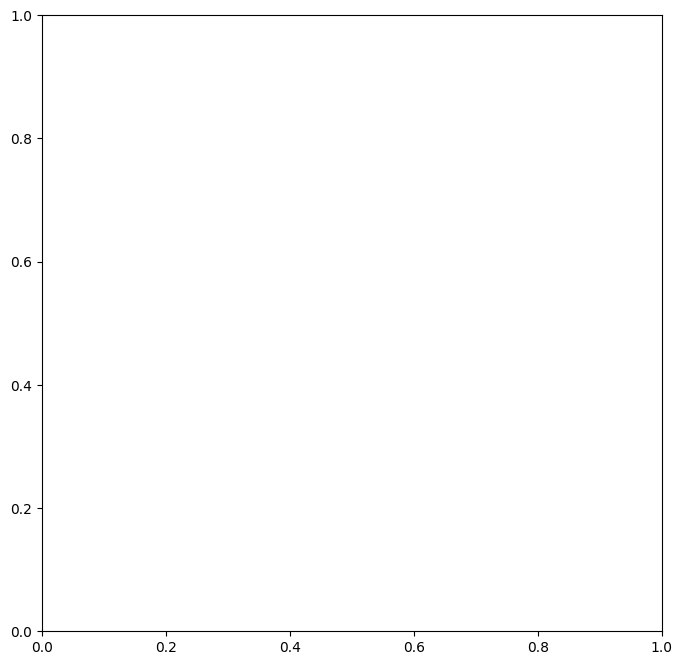

In [117]:
# Create figure for animation
fig, ax = plt.subplots(figsize=(8, 8))

# Create and run the model
model = SurveillanceModel(parameters)

# Run the simulation with animation
animation = ap.animate(model, fig, ax, animation_plot)

# Display the animation
IPython.display.HTML(animation.to_jshtml())
